# Data Merging Notebook
This notebook merges `Moto_chicane_50_P1.txt` (Xsens) and `Moto_chicane_50.tdms` (LabVIEW).

**Synchronization Strategy**:
- **Xsens**: Uses UTC time columns. Channel `Acc_X` (Longitudinal Acceleration).
- **TDMS**: Uses `wf_start_time`. Channel `Edges_RoueAR` (Rear Wheel Hall Sensor, 50 edges/rev).
- **Method**: 
    1. Derive Acceleration from TDMS `Edges_RoueAR` using an **Edge-Step Method** (calculating velocity over fixed edge intervals, e.g., 25 edges).
    2. Use Wheel Diameter (17") to calculate physical Speed (m/s) and Acceleration (m/s²).
    3. Synchronize by Cross-Correlating Xsens `Acc_X` with TDMS `Derived_Acc`.
    4. Compare GPS Speed (Xsens) vs Calculated Wheel Speed (TDMS).
    5. Merge aligned data.

In [1]:
import sys
#!{sys.executable} -m pip install pandas nptdms matplotlib scipy
import pandas as pd
from nptdms import TdmsFile
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Output formatting
pd.set_option('display.max_columns', None)

## 1. Load Xsens TXT Data

In [2]:
txt_path = 'Moto_chicane_100_P1.txt'

try:
    # Skip header
    df_txt = pd.read_csv(txt_path, sep='\t', skiprows=12)
    df_txt.columns = df_txt.columns.str.strip()
    
    # Construct AbsoluteTime
    req_cols = ['UTC_Year', 'UTC_Month', 'UTC_Day', 'UTC_Hour', 'UTC_Minute', 'UTC_Second', 'UTC_Nano']
    if all(col in df_txt.columns for col in req_cols):
        df_txt = df_txt.dropna(subset=req_cols)
        time_series = pd.to_datetime(df_txt[['UTC_Year', 'UTC_Month', 'UTC_Day', 'UTC_Hour', 'UTC_Minute', 'UTC_Second']].astype(int).rename(columns={
            'UTC_Year': 'year', 'UTC_Month': 'month', 'UTC_Day': 'day',
            'UTC_Hour': 'hour', 'UTC_Minute': 'minute', 'UTC_Second': 'second'
        }))
        df_txt['AbsoluteTime'] = time_series + pd.to_timedelta(df_txt['UTC_Nano'], unit='ns')
        print(f"Xsens Data Loaded. Range: {df_txt['AbsoluteTime'].min()} - {df_txt['AbsoluteTime'].max()}")
        
        # --- NEW: Calculate GPS Speed if available ---
        if 'Vel_N' in df_txt.columns and 'Vel_E' in df_txt.columns:
             # Ensure numeric
             df_txt['Vel_N'] = pd.to_numeric(df_txt['Vel_N'], errors='coerce').fillna(0)
             df_txt['Vel_E'] = pd.to_numeric(df_txt['Vel_E'], errors='coerce').fillna(0)
             df_txt['GPS_Speed'] = np.sqrt(df_txt['Vel_N']**2 + df_txt['Vel_E']**2)
             print("Calculated Xsens GPS Speed from Vel_N and Vel_E")
        elif 'Velocity' in df_txt.columns:
             df_txt['GPS_Speed'] = pd.to_numeric(df_txt['Velocity'], errors='coerce').fillna(0)
             print("Using existing Velocity column as GPS Speed")
        else:
             print("Warning: Velocity columns (Vel_N, Vel_E or Velocity) not found for GPS Speed calculation.")
             # Print columns to help debug
             # print(df_txt.columns)

    else:
        print("Error: Missing UTC columns in TXT file.")

    # Clean Acc_X
    df_txt['Acc_X'] = pd.to_numeric(df_txt['Acc_X'], errors='coerce').fillna(0)

except Exception as e:
    print(f"Error loading TXT: {e}")

Xsens Data Loaded. Range: 2025-11-04 14:29:37.248402635 - 2025-11-04 14:30:32.440893843
Calculated Xsens GPS Speed from Vel_N and Vel_E


## 2. Load TDMS Data & Derive Speed/Acceleration (Physical Units)

TDMS Data Loaded. Range: 2025-11-04 14:29:36.687152 - 2025-11-04 14:30:31.684652
TDMS Sampling Rate: 400.00 Hz
Derived Acceleration (m/s²) using 150-Edge Step. Wheel Dia=18.0"


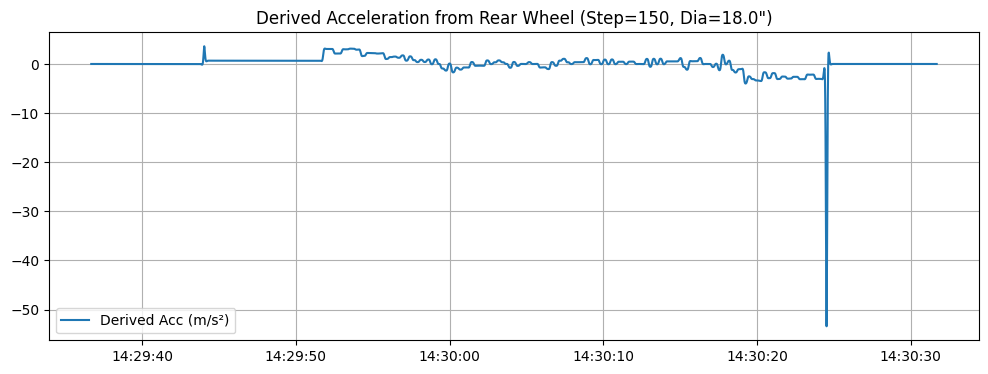

Available Channels in TDMS: ['AccAV_Moto', 'AccAR_Moto', 'Deb_Susp_AVG_Moto', 'Deb_Susp_AVD_Moto', 'Angle_Guidon', 'Edges_RoueAR', 'AbsoluteTime', 'Derived_Acc', 'Derived_Speed']


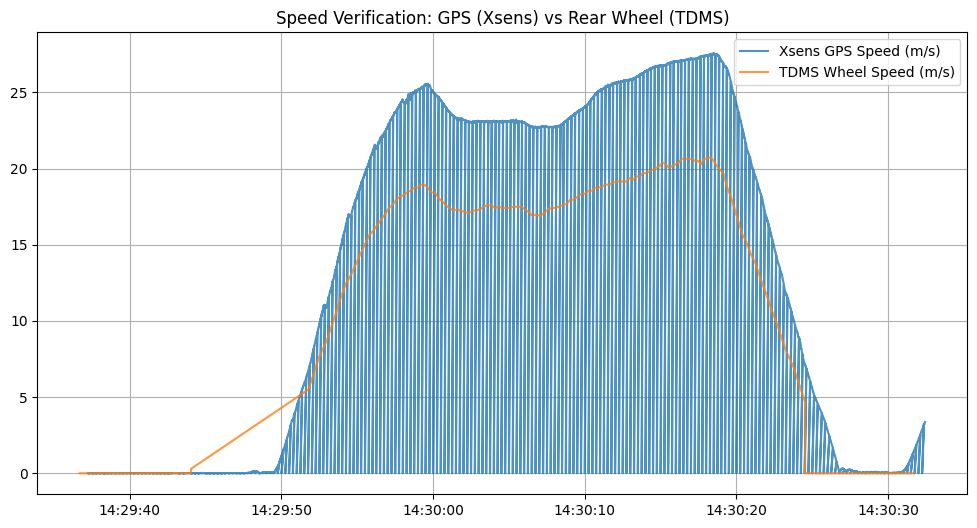

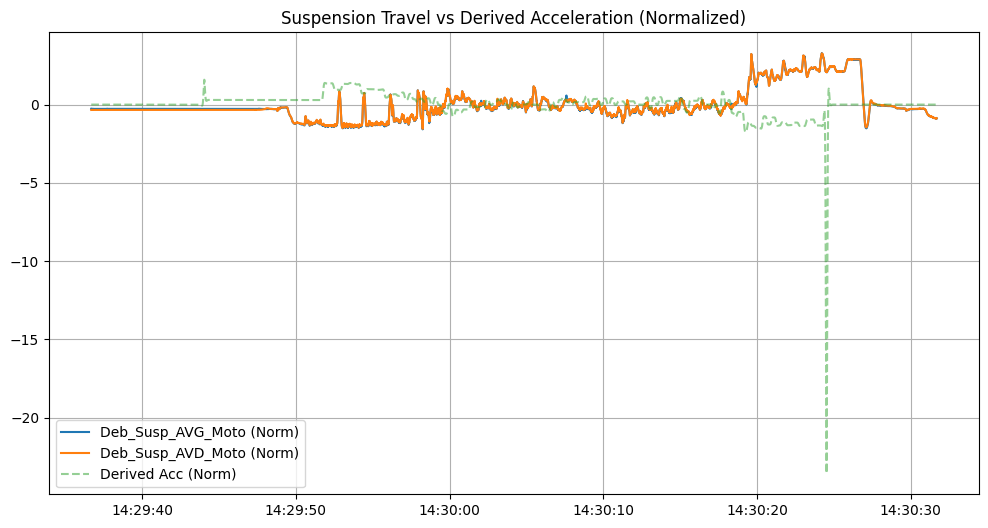

In [3]:
tdms_path = 'Moto_chicane_100.tdms'

try:
    tdms_file = TdmsFile.read(tdms_path)
    # Focus on group 'P1'
    group = tdms_file['P1']
    df_tdms = group.as_dataframe()
    
    # Construct Time
    properties = group.channels()[0].properties
    start_time = properties.get('wf_start_time')
    increment = properties.get('wf_increment')
    
    if start_time and increment:
        start_time_pd = pd.to_datetime(start_time).tz_localize(None)
        df_tdms['AbsoluteTime'] = start_time_pd + pd.to_timedelta(np.arange(len(df_tdms)) * increment, unit='s')
        print(f"TDMS Data Loaded. Range: {df_tdms['AbsoluteTime'].min()} - {df_tdms['AbsoluteTime'].max()}")
        print(f"TDMS Sampling Rate: {1/increment:.2f} Hz")
    
    # --- Derive Acceleration from Edges_RoueAR (Improved Edge-Step Method) ---
    # User Request: Calculate speed with a step of 25 or 50 edges to smooth quantization noise.
    # User Request: Wheel diameter is ~17 inches.
    
    edges = df_tdms['Edges_RoueAR']
    step_edges = 150

    # Constants for Physical Conversion
    WHEEL_DIA_INCH = 18.0
    WHEEL_CIRCUM_M = WHEEL_DIA_INCH * 0.0254 * np.pi
    EDGES_PER_REV = 50.0
    METERS_PER_EDGE = WHEEL_CIRCUM_M / EDGES_PER_REV
    
    # 1. Inverse Interpolation: Find Time(Edges)
    # We need unique, strictly increasing edge counts for interpolation to be valid.
    # dropping duplicates keeps the first occurrence of each edge count (timestamp of the edge event)
    df_unique = df_tdms.drop_duplicates(subset=['Edges_RoueAR'], keep='first')
    
    if len(df_unique) > 100:
        u_counts = df_unique['Edges_RoueAR'].values
        u_times_ns = df_unique['AbsoluteTime'].astype(np.int64).values
        
        # 2. Define a target grid of edges (e.g. 0, 25, 50...)
        min_edge = u_counts.min()
        max_edge = u_counts.max()
        # Create grid
        edge_grid = np.arange(np.ceil(min_edge/step_edges)*step_edges, max_edge, step_edges)
        
        # 3. Interpolate Time at these grid points
        # T_grid = Time(Edge_grid)
        t_grid_ns = np.interp(edge_grid, u_counts, u_times_ns)
        
        # 4. Calculate Speed: Step / Delta_Time
        dt_grid_ns = np.diff(t_grid_ns)
        dt_grid_s = dt_grid_ns * 1e-9
        
        # Speed (edges/s)
        speed_grid_edges_s = step_edges / dt_grid_s
        # Speed (m/s)
        speed_grid_mps = speed_grid_edges_s * METERS_PER_EDGE
        
        # 5. Map Speed back to original Time domain
        # T_mid is the center time of the interval over which speed was calculated
        t_mid_ns = (t_grid_ns[:-1] + t_grid_ns[1:]) / 2
        
        # Interpolate Speed(Time) onto the full TDMS time grid
        full_time_ns = df_tdms['AbsoluteTime'].astype(np.int64).values
        speed_full_mps = np.interp(full_time_ns, t_mid_ns, speed_grid_mps, left=0, right=0)
        
        # 6. Derive Acceleration (m/s^2)
        # Use central difference (gradient) for cleaner derivative than single-sided diff
        acc_full_mps2 = np.gradient(speed_full_mps, increment)
        
        # 7. Low-Pass Filter
        b, a = signal.butter(2, 5, fs=1/increment, btype='low') 
        df_tdms['Derived_Acc'] = signal.filtfilt(b, a, acc_full_mps2)
        df_tdms['Derived_Speed'] = speed_full_mps # Save speed in m/s
        
        print(f"Derived Acceleration (m/s²) using {step_edges}-Edge Step. Wheel Dia={WHEEL_DIA_INCH}\"")

        # Plot Derived Acc
        plt.figure(figsize=(12,4))
        plt.plot(df_tdms['AbsoluteTime'], df_tdms['Derived_Acc'], label='Derived Acc (m/s²)')
        plt.title(f"Derived Acceleration from Rear Wheel (Step={step_edges}, Dia={WHEEL_DIA_INCH}\")")
        plt.legend()
        plt.grid(True)
        plt.show()
        
    else:
        print("Warning: Not enough unique edge counts for Edge-Step method. Falling back to simple diff.")
        # Fallback
        diff_edges = edges.diff().fillna(0)
        speed_edges_s = diff_edges.rolling(window=25, center=True).mean().fillna(0) / increment
        speed_mps = speed_edges_s * METERS_PER_EDGE
        
        acc_derived = speed_mps.diff().fillna(0) / increment
        b, a = signal.butter(2, 5, fs=1/increment, btype='low')
        df_tdms['Derived_Acc'] = signal.filtfilt(b, a, acc_derived)
        df_tdms['Derived_Speed'] = speed_mps
        
        plt.figure(figsize=(12,4))
        plt.plot(df_tdms['AbsoluteTime'], df_tdms['Derived_Acc'])
        plt.title("Derived Acceleration (Fallback Method, m/s²)")
        plt.show()
    
    # --- Signal Exploration & GPS Comparison ---
    print("Available Channels in TDMS:", df_tdms.columns.tolist())
    
    # 1. Compare Speeds if Xsens GPS Speed was calculated
    if 'df_txt' in globals() and 'GPS_Speed' in df_txt.columns:
        plt.figure(figsize=(12,6))
        plt.plot(df_txt['AbsoluteTime'], df_txt['GPS_Speed'], label='Xsens GPS Speed (m/s)', alpha=0.8)
        plt.plot(df_tdms['AbsoluteTime'], df_tdms['Derived_Speed'], label='TDMS Wheel Speed (m/s)', alpha=0.8)
        plt.title("Speed Verification: GPS (Xsens) vs Rear Wheel (TDMS)")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No GPS Speed available for comparison.")
        
    # 2. Check for Suspension Travel
    suspension_cols = [c for c in df_tdms.columns if 'Deb' in c or 'ssp' in c.lower()]
    if suspension_cols:
        plt.figure(figsize=(12,6))
        for col in suspension_cols:
             sig = df_tdms[col]
             norm_sig = (sig - sig.mean()) / (sig.std() + 1e-6)
             plt.plot(df_tdms['AbsoluteTime'], norm_sig, label=f'{col} (Norm)')
        norm_acc = (df_tdms['Derived_Acc'] - df_tdms['Derived_Acc'].mean()) / (df_tdms['Derived_Acc'].std() + 1e-6)
        plt.plot(df_tdms['AbsoluteTime'], norm_acc, label='Derived Acc (Norm)', alpha=0.5, linestyle='--')
        plt.title("Suspension Travel vs Derived Acceleration (Normalized)")
        plt.legend()
        plt.grid(True)
        plt.show()

except Exception as e:
    print(f"Error in TDMS processing: {e}")

## 3. Synchronization (Cross-Correlation)

Calculated Time Shift (TDMS needs to shift by): -0.210 s


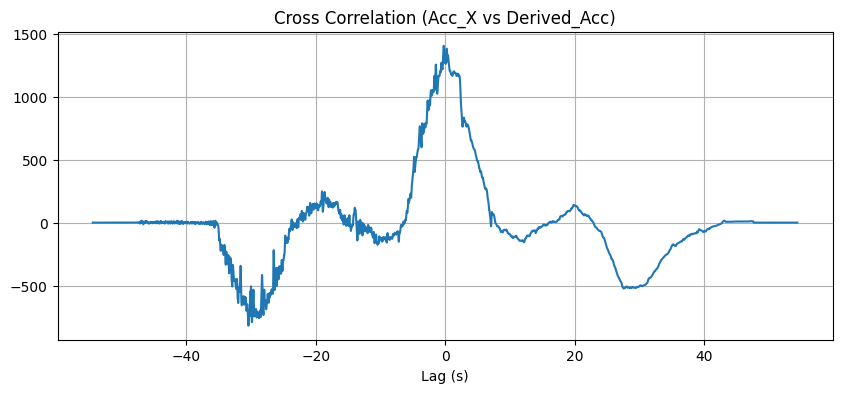

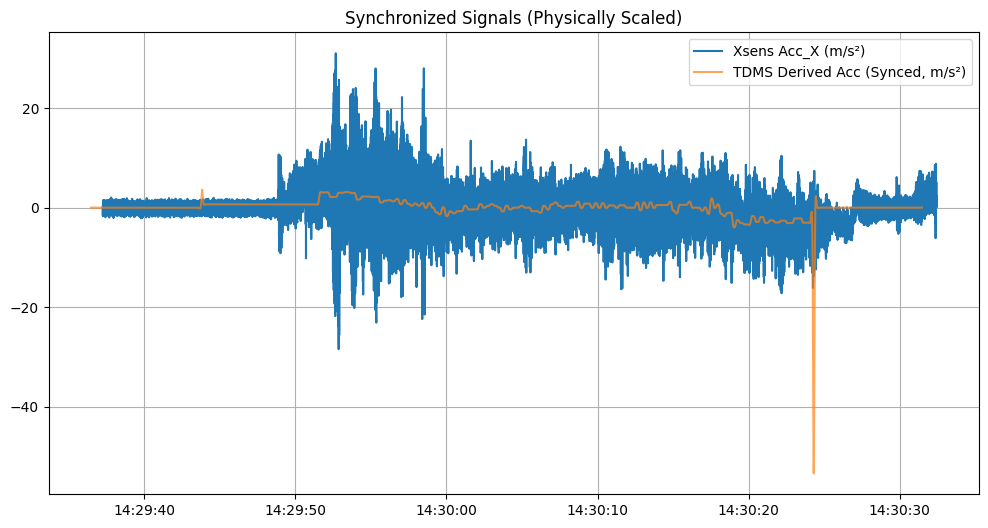

In [4]:
try:
    # Resample both to common grid for correlation (e.g. 100Hz)
    target_freq = 100.0
    dt_common = 1/target_freq
    
    # Common time range (intersection)
    t_min = max(df_txt['AbsoluteTime'].min(), df_tdms['AbsoluteTime'].min())
    t_max = min(df_txt['AbsoluteTime'].max(), df_tdms['AbsoluteTime'].max())
    
    common_time = pd.date_range(start=t_min, end=t_max, freq=f'{int(1000/target_freq)}ms')
    
    # Interpolate signals
    # Xsens Acc_X
    xsens_interp = np.interp(
        common_time.astype(np.int64), 
        df_txt['AbsoluteTime'].astype(np.int64), 
        df_txt['Acc_X']
    )
    
    # TDMS Derived Acc (Now in m/s^2)
    tdms_interp = np.interp(
        common_time.astype(np.int64), 
        df_tdms['AbsoluteTime'].astype(np.int64), 
        df_tdms['Derived_Acc']
    )
    
    # Normalize
    xsens_norm = (xsens_interp - np.mean(xsens_interp)) / (np.std(xsens_interp) + 1e-6)
    tdms_norm = (tdms_interp - np.mean(tdms_interp)) / (np.std(tdms_interp) + 1e-6)
    
    # Cross Correlate
    correlation = signal.correlate(xsens_norm, tdms_norm, mode='full')
    lags = signal.correlation_lags(len(xsens_norm), len(tdms_norm), mode='full')
    lag = lags[np.argmax(correlation)]
    
    time_shift = lag * dt_common
    print(f"Calculated Time Shift (TDMS needs to shift by): {time_shift:.3f} s")
    
    plt.figure(figsize=(10,4))
    plt.plot(lags * dt_common, correlation)
    plt.title("Cross Correlation (Acc_X vs Derived_Acc)")
    plt.xlabel("Lag (s)")
    plt.grid(True)
    plt.show()
    
    # Apply Shift
    df_tdms['AbsoluteTime_Synced'] = df_tdms['AbsoluteTime'] + pd.to_timedelta(time_shift, unit='s')
    
    # Verification Plot
    plt.figure(figsize=(12,6))
    plt.plot(df_txt['AbsoluteTime'], df_txt['Acc_X'], label='Xsens Acc_X (m/s²)')
    plt.plot(df_tdms['AbsoluteTime_Synced'], df_tdms['Derived_Acc'], label='TDMS Derived Acc (Synced, m/s²)', alpha=0.7)
    plt.title("Synchronized Signals (Physically Scaled)")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error in Synchronization: {e}")

## 4. Merge and Save

In [5]:
try:
    # We will interpolate TDMS data onto Xsens timestamps (Master = Xsens)
    
    df_merged = df_txt.copy()
    
    # Create interpolation function for relevant TDMS columns
    x_target = df_merged['AbsoluteTime'].astype(np.int64)
    x_source = df_tdms['AbsoluteTime_Synced'].astype(np.int64)
    
    # Columns to merge (exclude time)
    cols_to_merge = [c for c in df_tdms.columns if c not in ['AbsoluteTime', 'AbsoluteTime_Synced']]
    
    for col in cols_to_merge:
        if pd.api.types.is_numeric_dtype(df_tdms[col]):
            df_merged[f'TDMS_{col}'] = np.interp(x_target, x_source, df_tdms[col])
            
    # Save
    output_filename = 'Moto_Chicane_50_Merged_v2.csv'
    df_merged.to_csv(output_filename, index=False)
    print(f"Merged data saved to {output_filename}")

    # Display header
    cols_view = ['AbsoluteTime', 'Acc_X', 'GPS_Speed', 'TDMS_Derived_Acc', 'TDMS_Derived_Speed']
    print(df_merged[[c for c in cols_view if c in df_merged.columns]].head())

except Exception as e:
    print(f"Error merging data: {e}")

Merged data saved to Moto_Chicane_50_Merged_v2.csv
                   AbsoluteTime     Acc_X  GPS_Speed  TDMS_Derived_Acc  \
0 2025-11-04 14:29:37.248402635  0.022930   0.003753      8.994904e-64   
1 2025-11-04 14:29:37.250902635 -1.618082   0.007109      1.034005e-63   
2 2025-11-04 14:29:37.253402635 -0.505009   0.008028      1.177587e-63   
3 2025-11-04 14:29:37.255902635  0.578726   0.006494      1.330350e-63   
4 2025-11-04 14:29:37.258402635  0.348784   0.006551      1.492350e-63   

   TDMS_Derived_Speed  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
